# **Custom Cloud Mask Performance Evaluation in the Alps**

* **Products used: s2_l2a**
* This notebook is run the Colab environment
* 07-12-2022

<br>

***

<br>

## **Background**

The cloud mask provided in the SCL band of Sentinel-2 product in Data Cube shows limited performance in distinguishing cloud objects in the presence of snow as well as other bright features. A custom cloud mask is made by integrating statistical information of S2 scenes using proposed NDCI (Normalized Difference Cloud Index). Here is an example showing the accuracy assessment by converting the script from Open Data Cube (ODC) to gdal and downloading scenes in the Google Earth Engine (GEE).

***

<br>

## **Description**

The workflow can be divided into the following:

<br>

**1) Import scene for custom cloud mask generation and scl band acquisition**

**2) Develope GDAL function for the implementation of cloud mask outside of Open Data Cube**

**3) Import validation data (sampling points) generated from QGIS application**

**4) Accuracy assessment & Calculation of confusion matrix**

***

### Set Up Environment

Install and import libraries required for the following computation

In [2]:
! pip install rasterio

     |████████████████████████████████| 19.3 MB 6.0 MB/s 


In [3]:
! pip install geopandas

     |████████████████████████████████| 1.0 MB 15.1 MB/s 
     |████████████████████████████████| 15.4 MB 48.7 MB/s 
     |████████████████████████████████| 6.3 MB 50.0 MB/s 


In [5]:
import scipy
import sys
import numpy as np
from scipy import ndimage
from osgeo import gdal
from osgeo.gdalconst import *
import os
import glob
import rasterio as rio
from osgeo import gdal_array
import xarray as xr
import geopandas as gpd
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
from holoviews import dim, opts
from matplotlib import cm
from matplotlib import colors

%matplotlib inline

In [6]:
# import specific libraries for histogram-based analysis
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm, kurtosis
from scipy.signal import find_peaks
from scipy.signal import argrelmin

Connect to Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Check files in the current directory, the following files are needed:

* Geotiff files of the Sentinel-2 scenes for evaluation
* SCL band of the scenes
* Shapefile for cloud objects **(For validation)**
* Shapefile for non-cloud objects - water bodies, land features **(For validation)**

In [ ]:
print(os.popen('ls /content/drive/MyDrive/BurkinaFaso').read())

## Data Import

In [8]:
# Open the new tiff file

filepath = r"/content/drive/MyDrive/Alps/alps_s2_20190320.tif"

# Open the file:
dataset = gdal.Open(filepath)
dataset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7ff90e90e960> >

In [ ]:
dataset.GetRasterBand(1).DataType

2

In [ ]:
dataset.GetRasterBand(1).ReadAsArray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

## First Visualization
* First Band

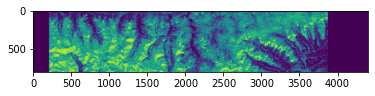

In [10]:
plt.imshow(dataset.GetRasterBand(1).ReadAsArray())

* Second Band

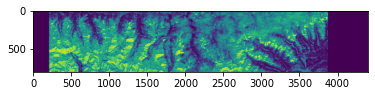

In [107]:
plt.imshow(dataset.GetRasterBand(2).ReadAsArray())

## Function Application

In [ ]:
newMask = ssmask(dataset)

In [29]:
newMask.shape

(797, 4399)

In [46]:
np.unique(newMask)

array([ 0.,  1., 11., 12., 99.])

## Classification Results

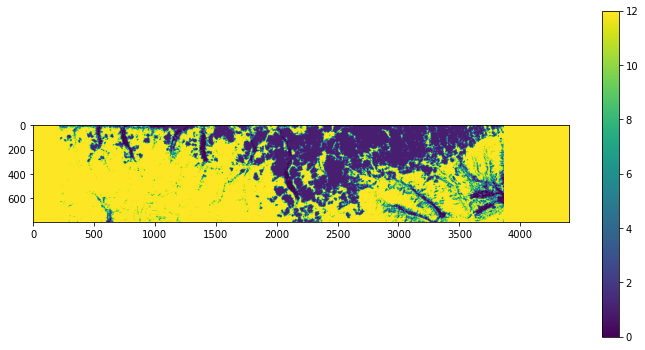

In [89]:
plt.figure(figsize=(12,6))
plt.imshow(newMask, vmax=12)
plt.colorbar()

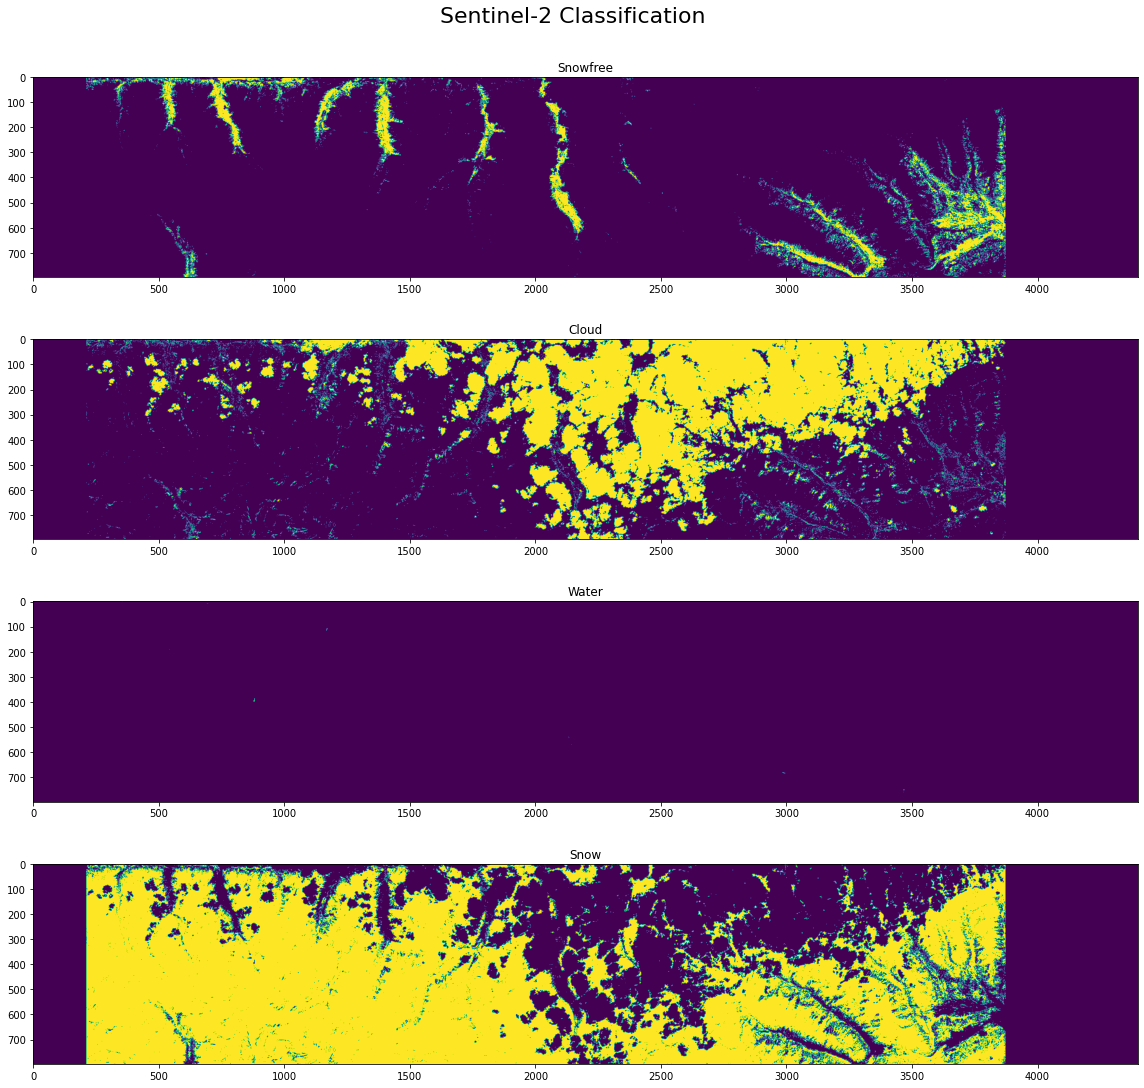

In [106]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(16,16))

ax1.imshow(newMask==0)
ax1.set_title('Snowfree')

ax2.imshow(newMask==1)
ax2.set_title('Cloud')

ax3.imshow(newMask==11)
ax3.set_title('Water')

ax4.imshow(newMask==12)
ax4.set_title('Snow')

plt.suptitle("Sentinel-2 Classification", fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Check Subregions

Text(0.5, 1.0, 'S2 Imagery')

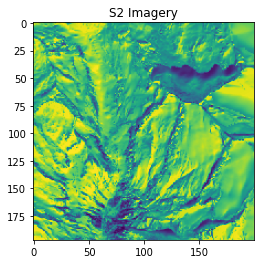

In [108]:
plt.imshow(dataset.GetRasterBand(1).ReadAsArray()[600:800,800:1000])
plt.title("S2 Imagery")

Text(0.5, 1.0, 'Snow')

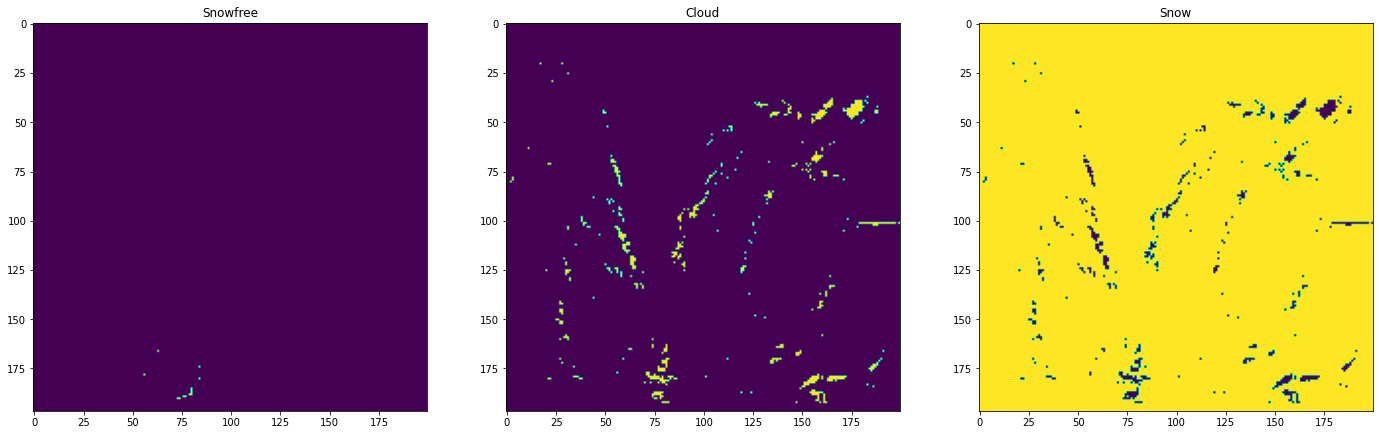

In [113]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

ax1.imshow(newMask[600:800,800:1000]==0)
ax1.set_title('Snowfree')

ax2.imshow(newMask[600:800,800:1000]==1)
ax2.set_title('Cloud')

ax3.imshow(newMask[600:800,800:1000]==12)
ax3.set_title('Snow')

* ## SCL Band

In [114]:
scl_path = r"/content/drive/MyDrive/Alps/cm_s2_20190320.tif"

# Import the original cloud mask
scl_ds = rio.open(scl_path)

# Convert dataset into a 2D numpy array
scl_mat = np.zeros(scl_ds.shape, dtype=rio.float32)
scl_mat = scl_ds.read(1)

# Matrix value
scl_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

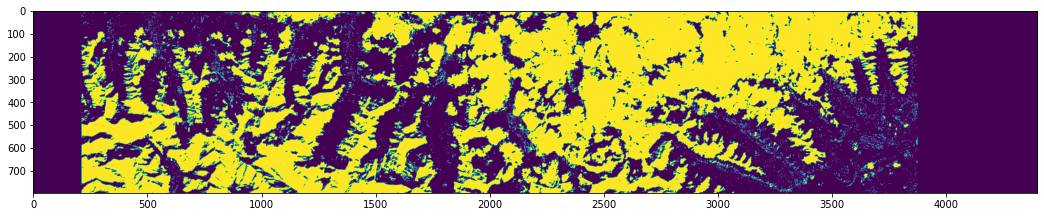

In [117]:
plt.figure(figsize=(18,6))
plt.imshow(scl_mat)

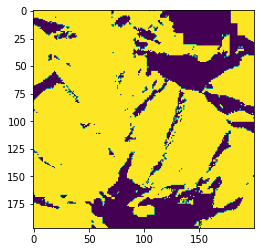

In [115]:
plt.imshow(scl_mat[600:800,800:1000])

## Output Export

In [118]:
cm_path = r"/content/drive/MyDrive/Alps/alps_s2_20190320.tif"
out_path = r"/content/drive/MyDrive/Alps/sscm_s2_20190320.tif"

with rio.open(cm_path) as src:
    ras_data = src.read()
    ras_meta = src.profile

# make any necessary changes to raster properties, e.g.:
ras_meta['dtype'] = "int32"
ras_meta['nodata'] = -99

with rio.open(out_path, 'w', **ras_meta) as dst:
  dst.write(newMask, 1)

# Functions

In [82]:
def ssmask(S2_data):
    """
    Sentinel 2 classification of cloud mask.
    Description
    ----------
    Generating cloud classification used in Burkina Faso.
    Parameters
    ----------
    S2_data: osgeo.gdal.Dataset
        Landsat-8 dataset with blue, green, red, nir, swir, and thermal bands
    Returns
    -------
    CM_data: osgeo.gdal.Dataset
        dataset with binary cloud mask, where cloud == 1, clear == 0, water == 11, snow == 12
    """
    print("Start building arrays")
    t = np.float32
    
    # Read Bands
    blue = S2_data.GetRasterBand(1).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    green = S2_data.GetRasterBand(2).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    red = S2_data.GetRasterBand(3).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    rededge3 = S2_data.GetRasterBand(4).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    nir = S2_data.GetRasterBand(5).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    vapour = S2_data.GetRasterBand(6).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    swir1 = S2_data.GetRasterBand(7).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    
    # Convert formats
    b = blue.astype(t)
    g = green.astype(t)
    e = rededge3.astype(t)
    r = red.astype(t)
    n = nir.astype(t)
    v = vapour.astype(t)
    s = swir1.astype(t)
    
    # Apply scale factors
    b = b * 0.00001
    g = g * 0.00001
    e = e * 0.00001
    r = r * 0.00001
    n = n * 0.00001
    s = s * 0.00001

    print("Blue Band: ", b)
    
    np.seterr(invalid='ignore')
    strength = 0.4
    
    print("01/10 Start snow classification")

    print("02/10 Initialize snow map array")
    CM = np.zeros(b.shape)

    print("03/10 Calculating Spectral Indices")
    ndsi = (g - s) / (g + s)
    ndvi = (n - r) / (n + r)
    ndci = (b - n) / (b + n)
    ndi = (g - n) / (g + n)    

    ###########SNOW MASK###############
    ndsi_exp = ndsi - (0.0652 * np.exp(1.8069 * ndvi))
    ndsi_div = ndsi - ((ndvi - 0.2883) / (-0.4828))
    ndwi = (g/10000 - n/10000)/(g/10000 + n/10000)
    ndsi_ci = ndsi - ndci
    
    ### Check for Water ###
    #CM[(e < 100) & (ndi > 0.7)] = 11
    #CM[(ndsi > 0) & (ndvi < 0.05) & (ndvi > -0.05) & (ndi > 0.7)] = 11
    CM[(ndsi > 0) & (ndi > 0.7) & (ndvi < 0.2)] = 11
        
    ### Check for Snow ###
    CM[(g > 4000) & (n > 4000) & (ndsi > 0.4)] = 12
    CM[(g > 4000) & (n > 4000) & (ndvi > 0.25) & (ndsi_exp >=0)] = 12
    CM[(g > 4000) & (n > 4000) & (ndvi > 0.2) & (ndvi < 0.25) & (ndsi_div > 0)] = 12
    CM[ndsi_ci > 0.5] = 12

    ndci_hist = ndci[(~np.isnan(ndci)) & (ndci != 0) & (CM != 11) & (CM != 12)]

    ##########################

    # Store statistics
    NDCI_min = np.quantile(ndci_hist,0.05) # minimum NDCI allowing 5% outliners
    NDCI_max = np.quantile(ndci_hist,0.95) # maximum NDCI allowing 5% outliners
    NDCI_std = np.std(ndci_hist) # NDCI standard deviation
    vapour_median = np.median(v[~np.isnan(v)]) # median for water vapour
    NDCI_skew = skew(ndci_hist) # NDCI skewness: how far is NDCI away from normal distribution
    NDCI_median = np.median(ndci_hist) # NDCI median
    NDCI_kur = kurtosis(ndci_hist) # NDCI kurtosis: depends on the shape of distribution
    
    # calculating the peak of NDCI histogram and detect number of peaks
    counts, bin_edges = np.histogram(ndci_hist) # get frequency count of every NDCI range groups
    peaks,_ = find_peaks(counts, prominence=len(ndci_hist)/50) # get all peaks (between increasing and decreasing counts)
    npeak = len(peaks.flatten()) # get the number of peaks
    
    print("04/10 Scene classification")
    
    # Classified Scene: All Clouds
    if NDCI_min >= -0.1:
        CM = np.zeros(b.shape)
        
    # Classified Scene: Mostly clouds
    elif NDCI_min < -0.1 and NDCI_min >= -0.3:
        if bin_edges[peaks[0]] < -0.3:
            thres = bin_edges[peaks[0]]
        else:
            thres = -0.3
        CM[(ndci > thres) & (CM != 11) & (CM != 12)] = 1 
    
    # Classified Scene: Mostly clouds
    
    # other condition for scene to be classify as mostly clouds: lower NDCI but histogram highly skewed towards high values
    # kurtosis values restricted to peak to be sharp for cloudy conditions
    # if clouds are dominant in scene, there should be only one peak in the histogram
    
    elif NDCI_min < -0.3 and NDCI_median > -0.35 and NDCI_kur > -1 and NDCI_skew < 0 and npeak == 1:
        print("Condition 3")
        if bin_edges[peaks[0]] < -0.3:
            thres = bin_edges[peaks[0]]
        else:
            thres = -0.3
        CM[(ndci > thres) & (CM != 11) & (CM != 12)] = 1
    
    # Classified Scene: Clear sky
    
    # either low NDCI for all pixels or low median with really sharp peak for sunny conditions
    
    elif NDCI_max < -0.3 or (NDCI_kur > 1.5 and NDCI_median < -0.4):
        print("Condition 4")
        print(v)
        CM[(ndci > -0.3) & (v > vapour_median*1.1) & (CM != 11) & (CM != 12)] = 1
    
    # Classified Scene: Partly clouds
    else:
        print("Condition 5")
        counts, bin_edges = np.histogram(ndci_hist, bins=30)
        if npeak <= 1:
            peak = np.argmax(counts)
            mode = (bin_edges[peak] + bin_edges[peak+1])/2 # check dominant NDCI value

            par = stats.percentileofscore(ndci_hist, mode) # get quantile for dominant NDCI value

            factor = 1 - NDCI_std # define fector to adjust NDCI threshold 
            # the more variant NDCI, the more conservative to define the end of NDCI cluster
            adj_factor = (100 - par)*(factor/50) # tune the value to make sure percentile lies within 0% and 100%
            refine = (par + adj_factor)/100
            NDCI_thres = np.quantile(ndci_hist,refine) # calculate the NDCI threshold

        else:
            min_indices = argrelmin(counts)[0]
            ind_min = np.argmin(counts[min_indices])
            ind_hist = min_indices[ind_min]
            NDCI_thres = (bin_edges[ind_hist] + (-0.4))/2
            strength = 0.5
        
        # default values false for neg: indicate negative strength
        neg = False
        
        # adjust strength depends on NDCI skewness (the proxy for cloud proportion)
        # to make sure consistent masking independent of weather condition
        if NDCI_skew > 1:
            strength = strength + 0.3
            if strength > 1:
                strength = 1 # make sure strength lies within 0 and 1
        elif NDCI_skew > 0 and NDCI_skew < 0.2: # less strength when there are few clouds
            strength = strength - 0.2
            if strength < 0:
                neg = True
                negative_adj = strength
                strength = 0
        elif NDCI_skew < -0.4: # increase strength when there are lots of clouds
            strength = strength + 0.3
            if strength > 1:
                strength = 1
                
        # apply strength to adjust the NDCI threshold
        if NDCI_thres <= 0:
            NDCI_thres_adjust = (NDCI_thres - 1) * strength * 2
            NDCI_thres_adjust = NDCI_thres_adjust + (strength * 2)
        else:
            NDCI_thres_adjust = (NDCI_thres + 1) * strength * -2
            NDCI_thres_adjust = NDCI_thres_adjust - (strength * -2)

        if neg == True:
            NDCI_thres_adjust = NDCI_thres_adjust + negative_adj/5 

        # use NDCI sknewness as the proxy for cloudyness of the scene
        # which is used for second condition depending on the water vapour value
        
        if NDCI_skew >= -0.5 and NDCI_skew < -0.3:
            CM[(ndci > NDCI_thres_adjust) & (v > np.quantile(v,0.45)) & (ndvi < 0.2) & (CM != 11) & (CM != 12)] = 1
            
        elif NDCI_skew < -0.5: # lower water vapour threshold for relatively cloudy condition
            CM[(ndci > NDCI_thres_adjust) & (v > np.quantile(v,0.3)) & (ndvi < 0.2) & (CM != 11) & (CM != 12)] = 1
 
        else: # higher water vapour threshold for relatively less cloudy condition
            CM[(ndci > NDCI_thres_adjust) & (v > np.quantile(v,0.5)) & (ndvi < 0.2) & (CM != 11) & (CM != 12)] = 1
        
    # sm_CM = ndimage.uniform_filter(CM, size=2, mode='nearest')
    # new_CM = (sm_CM == 1)
    # new_CM = new_CM.astype(int)
    
    CM[(np.isnan(b) == True) | (np.isnan(g) == True) | (np.isnan(s) == True) | (np.isnan(r) == True) | (np.isnan(n) == True)] = 99 # de-stripe
    CM[(b == 0) | (g == 0) | (s == 0) | (r == 0) | (n == 0)] = 99  # de-stripe

    return CM #new_CM